In [1]:
import os 
import re
from typing import List
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import pandas as pd

In [3]:
p = re.compile(r"(?P<date>\d{4}(-\d\d){2})_(\d\d-){2}\d\d_(?P<model>.*?)__(?P<n1>\d+)-(?P<n2>\d+)-(?P<rule>B\d*_S\d*V?)")

"""
2025-10-16_17-14-45_small_2_layer_seq_p4cnn__200-200-B3_S23
2025-10-16_17-31-10_small_2_layer_seq_p4cnn__200-200-B36_S23
2025-10-16_17-48-10_small_2_layer_seq_p4cnn__200-200-B3678_S34678
2025-10-16_18-03-39_small_2_layer_seq_p4cnn__200-200-B35678_S5678
2025-10-16_18-18-36_tiny_2_layer_seq_cnn__200-200-B3_S23
2025-10-16_18-27-04_tiny_2_layer_seq_cnn__200-200-B36_S23
2025-10-16_18-35-39_tiny_2_layer_seq_cnn__200-200-B3678_S34678
2025-10-16_18-44-26_tiny_2_layer_seq_cnn__200-200-B35678_S5678
2025-10-16_18-53-31_tiny_2_layer_seq_cnn__200-200-B3_S23
2025-10-16_18-59-38_tiny_2_layer_seq_cnn__200-200-B36_S23
2025-10-16_19-06-55_tiny_2_layer_seq_cnn__200-200-B3678_S34678
2025-10-16_19-14-16_tiny_2_layer_seq_cnn__200-200-B35678_S5678
2025-10-16_19-22-29_tiny_2_layer_seq_cnn__200-200-B3_S23
"""

p.match("2025-10-16_17-14-45_small_2_layer_seq_p4cnn__200-200-B3_S23").groupdict()

{'date': '2025-10-16',
 'model': 'small_2_layer_seq_p4cnn',
 'n1': '200',
 'n2': '200',
 'rule': 'B3_S23'}

In [2]:
def condition(s: str, date: str|List[str], rule: str, n1: int, n2: int):
    p = re.compile(r"(?P<date>\d{4}(-\d\d){2})_(\d\d-){2}\d\d_(?P<model>.*?)__(?P<n1>\d+)-(?P<n2>\d+)-(?P<rule>B\d*_S\d*V?)")
    
    match = p.match(s)
    
    try: 
        result_dict = match.groupdict()
    except Exception as e:
        print(f"EXCEPTION | {e}")
        return 0
    
    if not isinstance(date, list):
        date = [date]
    
    
    if result_dict["date"] not in date:
        return 0
    if result_dict["rule"] != rule or result_dict["n1"] != n1 or result_dict["n2"] != n2:
        return 0
    return 1
    

In [ ]:
axs: List[List[Axes]]|np.ndarray
fig: Figure

mean_smooth = lambda x:pd.Series(x).rolling(window=100, center=True, min_periods=1).median()

abbr_d = {
    'small_2_layer_seq_p4cnn': "P4CNN-small",
    'tiny_2_layer_seq_p4cnn': "P4CNN-tiny",
    'small_2_layer_seq_cnn' : "CNN-small",
    'tiny_2_layer_seq_cnn' : "CNN-tiny",
    'multiscale_0' : "MCNN",
    'multiscale_p4': "P4MCNN",
}

for idx, r in enumerate(["B3/S23", "B36/S23", "B3678/S34678", "B35678/S5678", "B2/S", "B345/S5", "B13/S012V", "B2/S013V"]):
    print("\n\n" + r)
    
    fig, axs = plt.subplots(2, 2, dpi=200, figsize=(16, 12))
    
    for s in os.listdir("."):
        p = re.compile(r"(?P<date>\d{4}(-\d\d){2})_(\d\d-){2}\d\d_(?P<model>.*?)__(?P<n1>\d+)-(?P<n2>\d+)-(?P<rule>B\d*_S\d*V?)")
        
        r_s = r.replace("/", "_")
        
        # print(s)
        if len(p.findall(s)) > 0:
            d = p.match(s).groupdict()
            # print(d["model"])
            if d["date"] in ["2025-10-17", "2025-10-18"] and d["rule"] == r_s:
                
                print(d["rule"])
                
                data_file = os.path.join("./", s, "training_path.npz")
                a_d: dict[str, np.ndarray] = np.load(data_file)
                # print(d.keys())
                
                plt.legend()
                
                label=abbr_d[d["model"]]
                
                line = axs[0][0].plot(mean_smooth(a_d["train_loss"]), label=label, alpha=0.8)[0]
                axs[0][0].plot(a_d["train_loss"], alpha=0.3, color=line.get_color())[0]
                axs[0][0].semilogy()
                axs[0][0].set_title("Train Loss")
                axs[0][0].set_ylabel("Loss")
                
                line = axs[0][1].plot(mean_smooth(a_d["grad_norm"]), label=label, alpha=0.8)[0]
                axs[0][1].plot(a_d["grad_norm"], alpha=0.3, color=line.get_color())[0]
                axs[0][1].semilogy()
                axs[0][1].set_title("Training Gradient Norm")
                
                
                line = axs[1][0].plot(mean_smooth(a_d["train_acc"]), label=label, alpha=0.8)[0]
                axs[1][0].plot(a_d["train_acc"], alpha=0.3, color=line.get_color())[0]
                axs[1][0].set_ylim(90, 101)
                axs[1][0].set_title("Training Accuracy")
                axs[1][0].set_ylabel("Accuracy (%)")
                
                axs[1][1].plot(a_d["val_acc"], label=label, alpha=0.8, marker='o')
                axs[1][1].set_ylim(90, 101)
                axs[1][1].set_title("Validation Accuracy")
                axs[1][1].set_ylabel("Accuracy (%)")
                
                d = None
        else:
            d = None
            continue

    for a in axs.flatten():
        a: Axes
        a.legend()
        a.set_xlabel("Train Iters")
        a.grid(alpha=0.2)

    fig.suptitle(f"Training Results of All models on life rule {r}")
    fig.tight_layout()

    fig.savefig(f"./training_results_{idx}-{r_s}")
    
    plt.cla()
    plt.close()



B3/S23
B3_S23
B3_S23
B3_S23
B3_S23
B3_S23


C:\Users\Gravitas\AppData\Local\Temp\ipykernel_60512\3451688878.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


B3_S23


B36/S23
B36_S23
B36_S23
B36_S23
B36_S23
B36_S23
B36_S23


B3678/S34678
B3678_S34678
B3678_S34678
B3678_S34678
B3678_S34678
B3678_S34678
B3678_S34678


B35678/S5678
B35678_S5678
B35678_S5678
B35678_S5678
B35678_S5678
B35678_S5678
B35678_S5678


B2/S
B2_S
B2_S
B2_S
B2_S
B2_S
B2_S


B345/S5
B345_S5
B345_S5
B345_S5
B345_S5
B345_S5
B345_S5


B13/S012V
B13_S012V
B13_S012V
B13_S012V
B13_S012V
B13_S012V
B13_S012V


B2/S013V
B2_S013V
B2_S013V
B2_S013V
B2_S013V
B2_S013V
B2_S013V


: 

In [33]:
abbr_d = {
    'small_2_layer_seq_p4cnn': "P4CNN-small",
    'tiny_2_layer_seq_p4cnn': "P4CNN-tiny",
    'small_2_layer_seq_cnn' : "CNN-small",
    'tiny_2_layer_seq_cnn' : "CNN-tiny",
    'multiscale_0' : "MCNN",
    'multiscale_p4': "P4MCNN",
}

for idx, r in enumerate(["B3/S23", "B36/S23", "B3678/S34678", "B35678/S5678", "B2/S", "B345/S5", "B13/S012V", "B2/S013V"]):
    print("\n\n" + r)
    
    for s in os.listdir("."):
        p = re.compile(r"(?P<date>\d{4}(-\d\d){2})_(\d\d-){2}\d\d_(?P<model>.*?)__(?P<n1>\d+)-(?P<n2>\d+)-(?P<rule>B\d*_S\d*V?)")
        
        r_s = r.replace("/", "_")
        
        # print(s)
        if len(p.findall(s)) > 0:
            d = p.match(s).groupdict()
            # print(d["model"])
            if d["date"] in ["2025-10-17", "2025-10-18"] and d["rule"] == r_s:
                
                
                data_file = os.path.join("./", s, "training_path.npz")
                a_d: dict[str, np.ndarray] = np.load(data_file)
                
                label=abbr_d[d["model"]]
                
                print(f"{label}")
                loss = a_d["train_loss"][-1]
                val_acc = a_d["val_acc"][-1]
                print(f"{loss:.4f}\\ {val_acc:.2f}%\n")
                
        else:
            d = None
            continue



B3/S23
P4CNN-small
0.0037\ 100.00%

P4CNN-tiny
0.3631\ 94.74%

CNN-small
0.0045\ 100.00%

CNN-tiny
0.7002\ 86.79%

MCNN
0.0055\ 99.97%

P4MCNN
0.0036\ 100.00%



B36/S23
P4CNN-small
0.0274\ 99.77%

P4CNN-tiny
0.4740\ 92.32%

CNN-small
0.0167\ 99.89%

CNN-tiny
0.3451\ 90.46%

MCNN
0.0262\ 98.94%

P4MCNN
0.0148\ 99.86%



B3678/S34678
P4CNN-small
0.0159\ 99.96%

P4CNN-tiny
0.4534\ 93.40%

CNN-small
0.0133\ 99.96%

CNN-tiny
0.2035\ 92.36%

MCNN
0.0660\ 98.19%

P4MCNN
0.0097\ 99.98%



B35678/S5678
P4CNN-small
0.0058\ 99.65%

P4CNN-tiny
0.0086\ 99.32%

CNN-small
0.0216\ 98.73%

CNN-tiny
0.0165\ 99.24%

MCNN
0.0955\ 99.52%

P4MCNN
0.0041\ 99.77%



B2/S
P4CNN-small
0.0022\ 100.00%

P4CNN-tiny
0.6136\ 88.79%

CNN-small
0.0023\ 100.00%

CNN-tiny
0.0231\ 99.74%

MCNN
0.0024\ 100.00%

P4MCNN
0.0034\ 100.00%



B345/S5
P4CNN-small
0.0028\ 100.00%

P4CNN-tiny
0.1534\ 98.34%

CNN-small
0.0065\ 100.00%

CNN-tiny
0.1710\ 96.25%

MCNN
0.0039\ 100.00%

P4MCNN
0.0119\ 99.92%



B13/S012V
P4CNN-small


In [114]:
line.get_color()

'#1f77b4'

## 网络权重可视化

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import math
import os

from model_conv import *
from einops import rearrange

In [2]:
pwd

'/Users/heruijie/BIMSA/result/predictor_life_simple'

In [3]:
from model_conv import SimpleCNNSmall2Layer


model = SimpleCNNSmall2Layer()
path_str_b36s23 = "2025-11-03_15-12-24_small_2_layer_seq_cnn__200-200-B3_S23"

rule = "B13_S012V"
model_name = "small_2_layer_seq_cnn"

In [190]:
import numpy as np
from typing import List
from matplotlib.axes import Axes
from matplotlib import cm
import re

abbr_d = {
    'small_2_layer_seq_p4cnn': "P4CNN-small",
    'tiny_2_layer_seq_p4cnn': "P4CNN-tiny",
    'small_2_layer_seq_cnn' : "CNN-small",
    'tiny_2_layer_seq_cnn' : "CNN-tiny",
    'multiscale_0' : "MCNN",
    'multiscale_p4': "P4MCNN",
}

for idx, r in enumerate(["B3/S23", "B2/S", "B13/S012V"]):
    print("\n\n" + r)
    
    for s in os.listdir("."):
        p = re.compile(r"(?P<date>\d{4}(-\d\d){2})_(\d\d-){2}\d\d_(?P<model>.*?)__(?P<n1>\d+)-(?P<n2>\d+)-(?P<rule>B\d*_S\d*V?)")
        
        r_s = r.replace("/", "_")
        
        # print(s)
        if len(p.findall(s)) > 0:
            d = p.match(s).groupdict()
            print(d["rule"])
            # print(d["model"])
            if d["date"] in ["2025-10-16", "2025-10-17", "2025-10-18"] and d["rule"] == r_s and d["model"] == model_name:
                
                model.load_state_dict(torch.load(os.path.join(s, "best_simple_life_SimpleCNNSmall_0.1.0.pth")))
                state_dict = model.state_dict()
                
                rule = d["rule"]
                
                for l_idx in range(1, 4):

                    conv_layer = f"conv{l_idx}"
                    kernel, bias = state_dict[f"{conv_layer}.weight"], state_dict[f"{conv_layer}.bias"]

                    col_num = 2 if kernel.shape[0] <= 4 else 4

                    fig, axs = plt.subplots(kernel.shape[0]//col_num, col_num, dpi=300, figsize=(max(col_num*3+4, 12), 
                                                                                                max(4, kernel.shape[0]//col_num*3)))
                    axs: np.ndarray|List[List[Axes]]
                    axs: np.ndarray|List[Axes] = axs.flatten()

                    vmin, vmax = -3, 3
                    cmap = 'RdBu'
                    im = None

                    for idx, (m, b) in enumerate(zip(kernel, bias)):
                        r_arr = rearrange(m, "(d c) w h -> (d w) (c h)", d=(2 if m.shape[0] > 2 else 1))
                        axs[idx].imshow(r_arr, cmap=cmap, vmin=vmin, vmax=vmax)
                        axs[idx].set_title(f"Filter {idx}\n$b={b:.2f}$, $\max_i |x_i|={r_arr.abs().max():.2f}$")
                        axs[idx].axis('off')

                        for i in range(r_arr.shape[1]//5):
                            axs[idx].add_patch(plt.Rectangle((5*i-0.5, -0.5), 5, r_arr.shape[0], linewidth=1, edgecolor='black', facecolor='none'))
                        for j in range(r_arr.shape[0]//5):
                            axs[idx].add_patch(plt.Rectangle((-0.5, 5*j-0.5), r_arr.shape[1], 5, linewidth=1, edgecolor='black', facecolor='none'))

                        for txt, map_minmax in zip(['max', 'min'], [np.argmax, np.argmin]):
                            row, col = np.unravel_index(map_minmax(r_arr), r_arr.shape)
                            
                            # row, col = idx // r_arr.shape[0], idx % r_arr.shape[0]
                            axs[idx].text(col, row, f'{r_arr[row, col].item():.1f}', ha='center', va='center',
                                        color="yellow" if abs(r_arr[row, col].item()) > vmax*0.8 else "black",
                                        fontsize=8)

                    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
                    fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                                cax=cbar_ax, 
                                label='Kernel Weight Value')
                    
                    # fig.suptitle(f"Weights of layer [{conv_layer}] in model {abbr_d[model_name]} trained on Rule [{rule}]", fontsize=16)
                    plt.tight_layout(rect=[0, 0, 0.9, 1])  # 给 colorbar 留空间
                    print(f"Writing... ./filters_{conv_layer}_{abbr_d[model_name]}_{rule}.png")
                    plt.savefig(f"./no_suptitle_filters_{rule}_{abbr_d[model_name]}_{conv_layer}.png")
                    plt.close()



B3/S23
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23


C:\Users\Gravitas\AppData\Local\Temp\ipykernel_43428\4251949285.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # 给 colorbar 留空间


Writing... ./filters_conv1_CNN-small_B3_S23.png
Writing... ./filters_conv2_CNN-small_B3_S23.png
Writing... ./filters_conv3_CNN-small_B3_S23.png
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678


B2/S
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
Writing... ./filters_conv1_CNN-small_B2_S.png
Writing... ./filters_conv2_CNN-small_B2_S.png
Writing... ./filters_conv3_CNN-small_B2_S.png
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B2_S
B345_S5
B13_S012V
B2_S013V
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678_S5678
B3_S23
B36_S23
B3678_S34678
B35678

torch.Size([2, 8, 5, 5])


/var/folders/bs/pbmws09d35qgn5630zhrlhb00000gn/T/ipykernel_97542/508467029.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


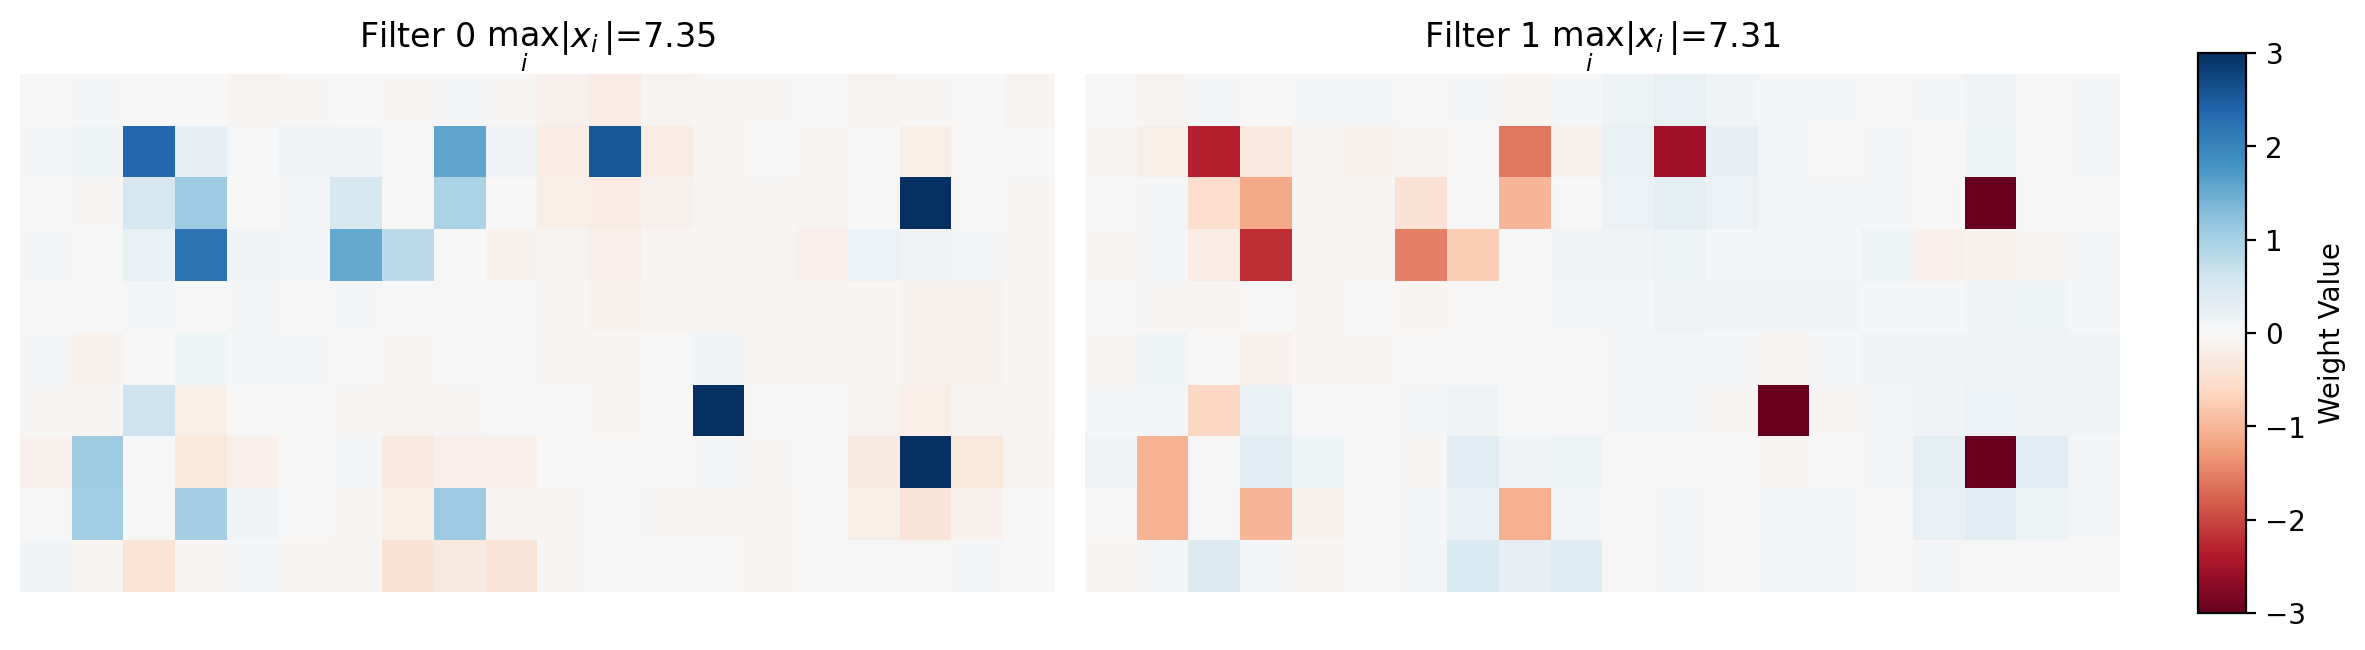

In [9]:
import numpy as np
from typing import List
from matplotlib.axes import Axes
from matplotlib import cm

model.load_state_dict(torch.load(os.path.join(path_str_b36s23, "best_simple_life_SimpleCNNSmall2Layer_0.1.0.pth")))
state_dict = model.state_dict()

kernel = state_dict["conv2.weight"]
print(kernel.shape)

col_num = 4 if kernel.shape[0] >= 8 else 2

fig, axs = plt.subplots(kernel.shape[0]//col_num, col_num, dpi=200, figsize=(12, 4))
axs: np.ndarray|List[List[Axes]]
axs: np.ndarray|List[Axes] = axs.flatten()

vmin, vmax = -3, 3
cmap = 'RdBu'
im = None

for idx, m in enumerate(kernel):
    axs[idx].imshow(rearrange(m, "(d c) w h -> (d w) (c h)", d=(2 if m.shape[0] > 2 else 1)), cmap=cmap, vmin=vmin, vmax=vmax)
    axs[idx].set_title(f"Filter {idx} $\max_i |x_i|$={m.abs().max():.2f}")
    axs[idx].axis('off')

plt.tight_layout()

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), cax=cbar_ax, label='Weight Value')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [191]:
model = SimpleP4CNNSmall()

d:\Internship\bimsa\.venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen/native/IndexingUtils.h:30.)
  full_mask[mask] = norms.to(torch.uint8)


In [196]:
state_dict = torch.load("./2025-10-17_23-00-41_small_2_layer_seq_p4cnn__200-200-B3_S23/best_simple_life_SimpleP4CNNSmall_0.1.0-p4.pth")

In [199]:
print(*state_dict.keys(), sep="\n")

conv1.weights
conv1._basisexpansion.block_expansion_('irrep_0', 'regular').sampled_basis
bn1.indices_4
bn1.batch_norm_[4].weight
bn1.batch_norm_[4].bias
bn1.batch_norm_[4].running_mean
bn1.batch_norm_[4].running_var
bn1.batch_norm_[4].num_batches_tracked
conv2.weights
conv2._basisexpansion.block_expansion_('regular', 'regular').sampled_basis
bn2.indices_4
bn2.batch_norm_[4].weight
bn2.batch_norm_[4].bias
bn2.batch_norm_[4].running_mean
bn2.batch_norm_[4].running_var
bn2.batch_norm_[4].num_batches_tracked
conv3.bias
conv3.weights
conv3.bias_expansion
conv3._basisexpansion.block_expansion_('regular', 'irrep_0').sampled_basis


In [204]:
state_dict["conv1.weights"].shape

torch.Size([176])

In [207]:
state_dict["conv1._basisexpansion.block_expansion_('irrep_0', 'regular').sampled_basis"].shape

torch.Size([11, 4, 1, 25])

In [17]:
conv_layer = f"conv2"
kernel = state_dict[f"{conv_layer}.weight"]
b = state_dict[f"{conv_layer}.bias"]

col_num = 2 if kernel.shape[0] <= 4 else 4

fig, axs = plt.subplots(kernel.shape[0]//col_num, col_num, dpi=300, figsize=(max(col_num*3+4, 12), 
                                                                            max(4, kernel.shape[0]//col_num*3)))
axs: np.ndarray|List[List[Axes]]
axs: np.ndarray|List[Axes] = axs.flatten()

vmin, vmax = -3, 3
cmap = 'RdBu'
im = None

for idx, m in enumerate(kernel):
    r_arr = rearrange(m, "(d c) w h -> (d w) (c h)", d=(2 if m.shape[0] > 2 else 1))
    axs[idx].imshow(r_arr, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[idx].set_title(f"Filter {idx}\n$b={b[idx]:.2f}$, $\max_i |x_i|={r_arr.abs().max():.2f}$")
    axs[idx].axis('off')

    for i in range(r_arr.shape[1]//5):
        axs[idx].add_patch(plt.Rectangle((5*i-0.5, -0.5), 5, r_arr.shape[0], linewidth=1, edgecolor='black', facecolor='none'))
    for j in range(r_arr.shape[0]//5):
        axs[idx].add_patch(plt.Rectangle((-0.5, 5*j-0.5), r_arr.shape[1], 5, linewidth=1, edgecolor='black', facecolor='none'))

    for txt, map_minmax in zip(['max', 'min'], [np.argmax, np.argmin]):
        row, col = np.unravel_index(map_minmax(r_arr), r_arr.shape)
        
        # row, col = idx // r_arr.shape[0], idx % r_arr.shape[0]
        axs[idx].text(col, row, f'{r_arr[row, col].item():.1f}', ha='center', va='center',
                    color="yellow" if abs(r_arr[row, col].item()) > vmax*0.8 else "black",
                    fontsize=8)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
            cax=cbar_ax, 
            label='Kernel Weight Value')

# fig.suptitle(f"Weights of layer [{conv_layer}] in model {abbr_d[model_name]} trained on Rule [{rule}]", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # 给 colorbar 留空间
print(f"Writing... ./filters_{conv_layer}_{model_name}_{rule}.png")
plt.savefig(f"./no_suptitle_filters_{rule}_{model_name}_{conv_layer}.png")
plt.close()

/var/folders/bs/pbmws09d35qgn5630zhrlhb00000gn/T/ipykernel_97542/2249869496.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # 给 colorbar 留空间


Writing... ./filters_conv2_small_2_layer_seq_cnn_B13_S012V.png
